<a href="https://colab.research.google.com/github/Oshgig/Portfolio/blob/main/Sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
sales = pd.read_csv('/content/drive/MyDrive/Projects/mock_kaggle.csv')
sales

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


### **PRE-PROCESSING**

In [ ]:
#Check if there is null value in the dataset
is_null = sales.isnull().sum()
is_null

data       0
venda      0
estoque    0
preco      0
dtype: int64

In [ ]:
#Convert the data column to a date format
sales['Date'] = pd.to_datetime(sales['data'])
sales.head()

,data,venda,estoque,preco,Date
0,2014-01-01,0,4972,1.29,2014-01-01
1,2014-01-02,70,4902,1.29,2014-01-02
2,2014-01-03,59,4843,1.29,2014-01-03
3,2014-01-04,93,4750,1.29,2014-01-04
4,2014-01-05,96,4654,1.29,2014-01-05


In [ ]:
# Drop the 'data' column
sales.drop('data', axis=1, inplace=True)

# Set the Date column as an index
sales.set_index('Date', inplace=True)

sales

,venda,estoque,preco
Date,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29
...,...,...,...
2016-07-27,98,3179,2.39
2016-07-28,108,3071,2.39
2016-07-29,128,4095,2.39


In [ ]:
sales.columns

Index(['venda', 'estoque', 'preco'], dtype='object')

In [ ]:
#Split to train and test data
train = sales[sales.index < '2016-01-01']
test = sales[sales.index >= '2016-01-01']

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 937 entries, 2014-01-01 to 2016-07-31
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   venda    937 non-null    int64  
 1   estoque  937 non-null    int64  
 2   preco    937 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 29.3 KB


## **EXPLORATORY DATA ANALYSIS**

<Axes: >

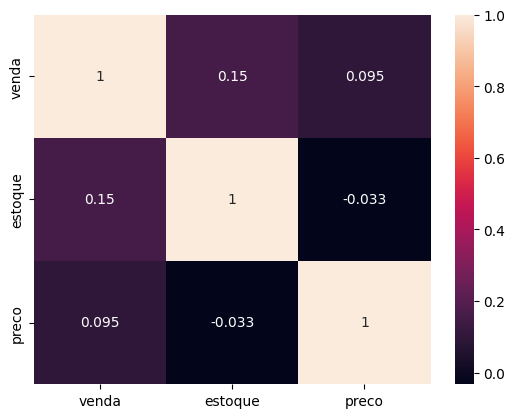

In [ ]:
#Correlation analysis
sns.heatmap(sales.corr(), annot=True)

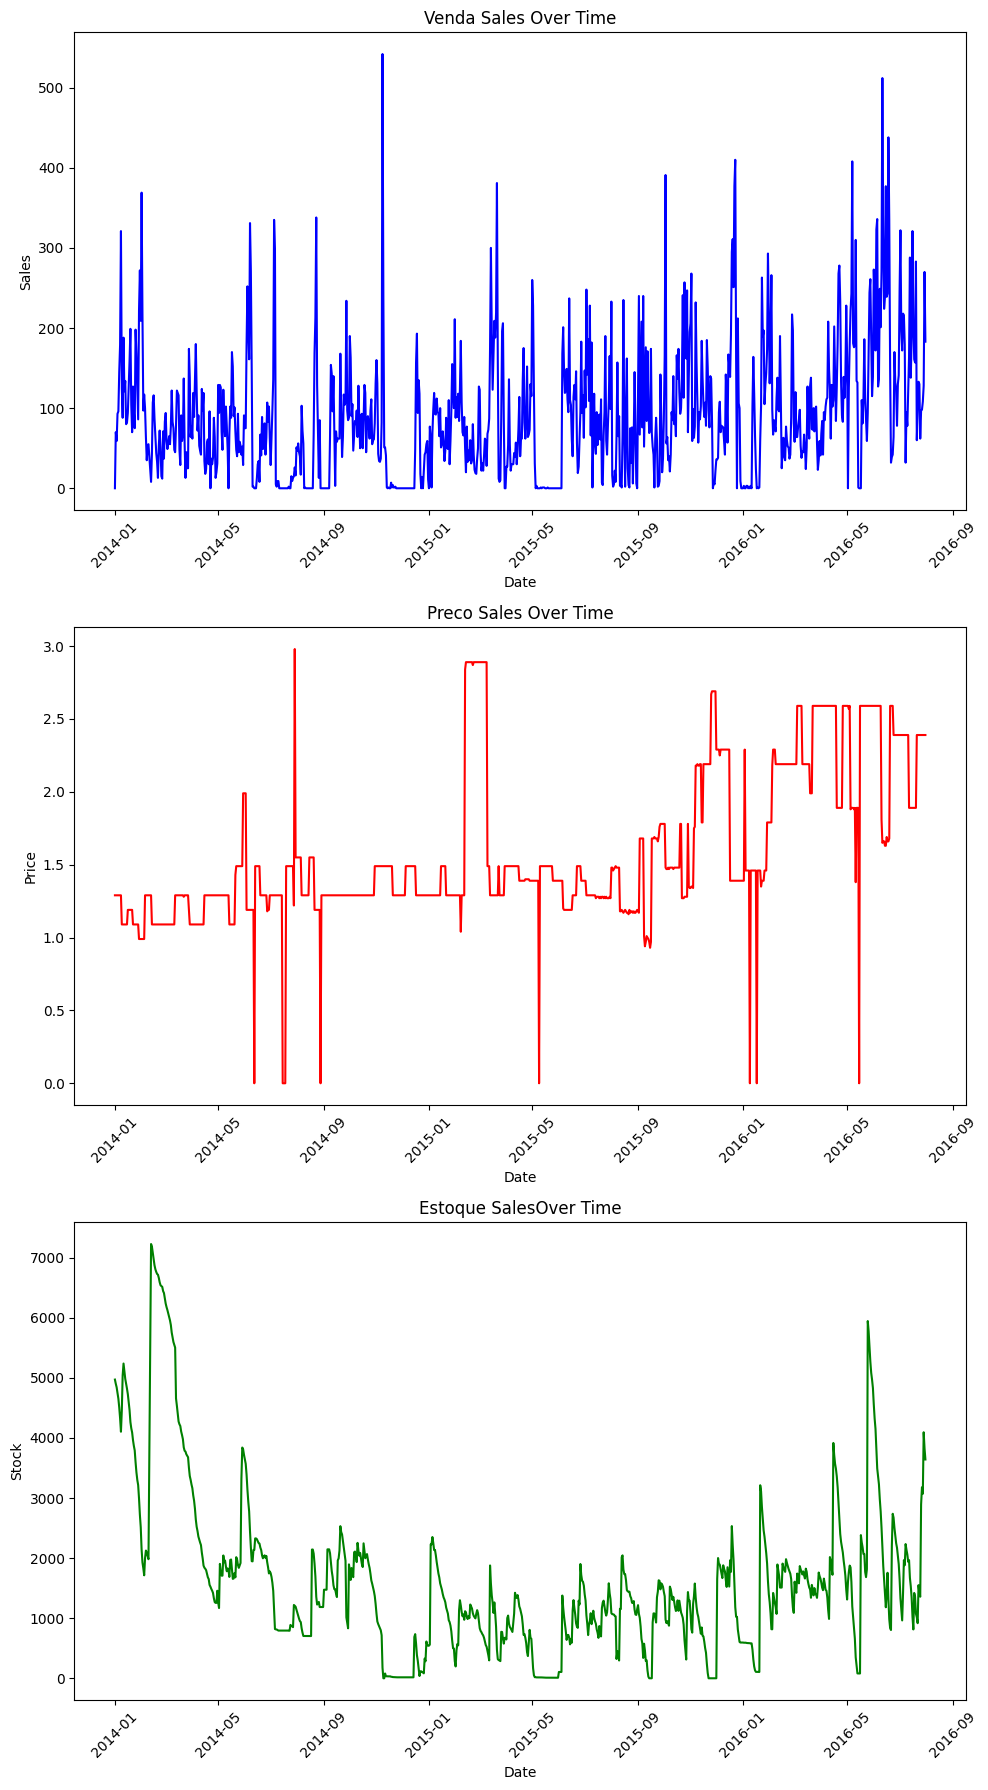

In [ ]:
#Create a subplot to view the sales of the products over the period of tikme
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Venda's plot
axs[0].plot(sales['venda'], linestyle='-', color='b')
axs[0].set_title('Venda Sales Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Sales')
axs[0].tick_params('x', rotation=45)

# Preco's plot
axs[1].plot(sales['preco'], linestyle='-', color='r')
axs[1].set_title('Preco Sales Over Time')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price')
axs[1].tick_params('x', rotation=45)

# Estoque's plot
axs[2].plot(sales['estoque'], linestyle='-', color='g')
axs[2].set_title('Estoque SalesOver Time')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Stock')
axs[2].tick_params('x', rotation=45)

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Daily Sales Over Time'}, xlabel='Date'>

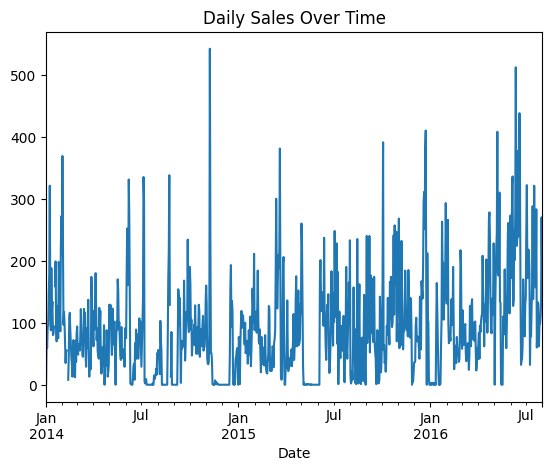

In [ ]:
# Assuming 'df' is your DataFrame
sales.index = pd.to_datetime(sales.index)  # Convert index to datetime
sales = sales.asfreq('D')  # Set frequency to daily

# Quick plot to visualize sales over time
sales['venda'].plot(title='Daily Sales Over Time')

In [ ]:
#Split to train and test data
# Calculate the split point
split_point = int(len(sales) * 0.8)

# Split the data
train = sales.iloc[:split_point]
test = sales.iloc[split_point:]

# Print the shapes of the resulting DataFrames
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (754, 3)
Test shape: (189, 3)


In [ ]:
train.head()

,venda,estoque,preco
Date,,,
2014-01-01,0.0,4972.0,1.29
2014-01-02,70.0,4902.0,1.29
2014-01-03,59.0,4843.0,1.29
2014-01-04,93.0,4750.0,1.29
2014-01-05,96.0,4654.0,1.29


In [ ]:
# ARIMA MODEL
p, d, q = 0, 1, 0

# Fit the ARIMA Model
model = ARIMA(train['venda'], order=(p, d, q))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
mse = mean_squared_error(test['venda'], forecast)
mae = mean_absolute_error(test['venda'], forecast)

print("MSE:", mse)
print("MAE:", mae)

MSE: 10505.349206349207
MAE: 87.87830687830687


In [ ]:
#Random Foreest

In [ ]:
#Random Forests, Gradient Boosting Machines (e.g., XGBoost, LightGBM), and Neural Networks.
#ARIMA
#LSTM
#Hybrid